In [2]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline, SelectTailK, LeaveTailK, DummyRegressor
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
from anrg.mp import MPRegressor
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [3]:
trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
# trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [4]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_comb = trn.groupby('Id').agg(['mean','std','median','count', 'min', 'max'])
trn_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_comb.columns.values)]
trn_comb = trn_comb.drop(['Expected_count', 'Expected_median', 'Expected_std', 'Expected_min','Expected_max'], axis =1)

# ignore id's where all Ref vales are NaN
trn_withRef_comb = trn_comb[pd.notnull(trn_comb.Ref_mean)]

print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 12.4313 secs


In [5]:
y = trn_withRef_comb['Expected_mean']
trn_withRef_comb = trn_withRef_comb.drop(['Expected_mean'], axis =1)

trn_withRef_comb['MP'] = np.log10(1+pow(pow(10, trn_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82))
X = trn_withRef_comb.loc[:, 'minutes_past_mean':'MP']  # NOTE: used range slicing on column

print X.shape, y.shape

(731556, 133) (731556,)


In [6]:
ttf = TargetThresholdFilter(threshold=45)
lpo = LogPlusOne()
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
base1 = Pipeline([('sel', LeaveTailK(K=1)), ('rf', RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=7))])  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
base2 = Pipeline([('sel', LeaveTailK(K=1)), ('xgb', xgb.sklearn.XGBRegressor(n_estimators=500, nthread=6))], copy = False)
base3 = Pipeline([('sel', LeaveTailK(K=1)), ('ri', Ridge(alpha=2.0))], copy = False)
base4 = Pipeline([('sel', LeaveTailK(K=1)), ('la', Lasso(alpha=0.01))], copy = False)
base5 = Pipeline([('sel', SelectTailK(K=1)), ('mp', DummyRegressor())], copy = False)
blender = Ridge(alpha=2)
clf = BlendedRegressor(base_models=(base1, base2, base3, base4, base5), blending_model=blender, blending_split=0.2, with_feature=True)
pip = Pipeline([('ttf',ttf), ('lpo',lpo), ('imp',imp), ('ss',ss), ('clf',clf)], copy=True)  # a Pipeline wrapper to chain'em up
def LogPlusOne_score(ground_truth, predictions, lpo=lpo):
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=False)  # define scoring metric

# CV

In [17]:
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=3)

[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-22.188152 -15.7min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-22.463025 -16.3min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.337652 -16.0min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-24.861429 -16.2min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.699062 -15.6min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-23.857426 -15.8min
[CV] no parameters to be set .........................................
[CV] .............. no parameters to be set, score=-19.849024 -15.2min
[CV] n

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 158.7min finished


In [14]:
# ttf = TargetThresholdFilter(threshold=45)
# base1 = RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=7)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
# base2 = xgb.sklearn.XGBRegressor(n_estimators=500, nthread=6) # base3 = Ridge(alpha=2.0)# base4 = Lasso(alpha=0.01) # base5: MP
# blender = Ridge(1)
# clf = BlendedRegressor(base_models=(base1, base2, base3, base4, base5), blending_model=blender, blending_split=0.1)
# pip = Pipeline([('ttf',ttf), ('lpo',lpo), ('imp',imp), ('ss',ss), ('clf',clf)])  # a Pipeline wrapper to chain'em up
print np.mean(scores), np.std(scores)
print pip.get_params()['steps']

-23.0830986257 1.58102456168
[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=1)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...t=False))]), Pipeline(copy=False,
     steps=[('sel', SelectTailK(K=1)), ('mp', DummyRegressor())])),
         blending_model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         blending_split=0.1, with_feature=False))]


In [18]:
# ttf = TargetThresholdFilter(threshold=45)
# base1 = RandomForestRegressor(n_estimators=500, max_features=0.2, max_depth=25, n_jobs=7)  # NOTE: n_jobs=-1 will use all of your cores, set to a prefered number e.g. 4
# base2 = xgb.sklearn.XGBRegressor(n_estimators=500, nthread=6) # base3 = Ridge(alpha=2.0)# base4 = Lasso(alpha=0.01) # base5: MP
# blender = Ridge(2)
# clf = BlendedRegressor(base_models=(base1, base2, base3, base4, base5), blending_model=blender, blending_split=0.2)
# pip = Pipeline([('ttf',ttf), ('lpo',lpo), ('imp',imp), ('ss',ss), ('clf',clf)])  # a Pipeline wrapper to chain'em up
print np.mean(scores), np.std(scores)
print pip.get_params()['steps']

-23.0804868909 1.58104365075
[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=1)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...ressor())]), Pipeline(copy=False,
     steps=[('sel', SelectTailK(K=1)), ('mp', DummyRegressor())])),
         blending_model=Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         blending_split=0.2, with_feature=True))]


In [10]:
# Sweep parameter
param_name, param_range='clf__blending_model__alpha', np.arange(1.5, 2.5, 0.25)
train_scores, test_scores= validation_curve(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, 
                          param_name=param_name, param_range=param_range, verbose=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)# Sweep parameter

[CV] clf__blending_model__alpha=1.5 ..................................
[CV] ....... clf__blending_model__alpha=1.5, score=-18.701770 -  47.5s
[CV] clf__blending_model__alpha=1.75 .................................
[CV] ...... clf__blending_model__alpha=1.75, score=-18.701138 -  47.4s
[CV] clf__blending_model__alpha=2.0 ..................................
[CV] ....... clf__blending_model__alpha=2.0, score=-18.698794 -  47.7s
[CV] clf__blending_model__alpha=2.25 .................................
[CV] ...... clf__blending_model__alpha=2.25, score=-18.699666 -  47.5s
[CV] clf__blending_model__alpha=1.5 ..................................
[CV] ....... clf__blending_model__alpha=1.5, score=-14.461044 -  47.6s
[CV] clf__blending_model__alpha=1.75 .................................
[CV] ...... clf__blending_model__alpha=1.75, score=-14.459920 -  47.7s
[CV] clf__blending_model__alpha=2.0 ..................................
[CV] ....... clf__blending_model__alpha=2.0, score=-14.458963 -  47.7s
[CV] c

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed: 24.6min
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 31.8min finished


[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=1)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...t=False))]), Pipeline(copy=False,
     steps=[('sel', SelectTailK(K=1)), ('mp', DummyRegressor())])),
         blending_model=Ridge(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         blending_split=0.1, with_feature=True))]
[0.5, 0.75, 1, 1.25, 1.5]
[-16.48869519 -16.4984791  -16.51418115 -16.50239642 -16.50757212]
[-16.93193277 -16.93090144 -16.93018647 -

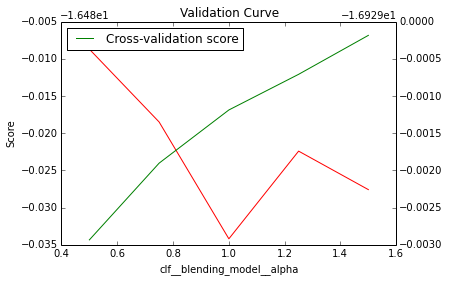

In [7]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# Sweep alpha = [0.5, 0.75, 1, 1.25, 1.5]
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=1)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...t=False))]), Pipeline(copy=False,
     steps=[('sel', SelectTailK(K=1)), ('mp', DummyRegressor())])),
         blending_model=Ridge(alpha=2.25, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         blending_split=0.175, with_feature=True))]
[ 1.5   1.75  2.    2.25]
[-16.53457031 -16.53353487 -16.53191321 -16.5337056 ]
[-16.9237328  -16.92340796 -16.92283777 -16.9225996

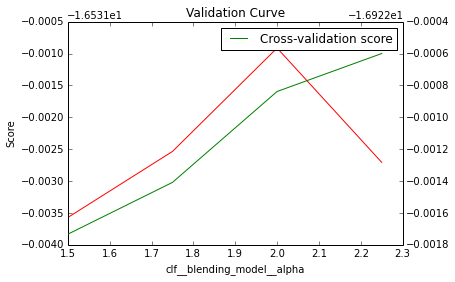

In [11]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# Sweep alpha = np.arange(1.5, 2.5, 0.25)
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

In [8]:
# Sweep parameter
param_name, param_range='clf__blending_split', [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175]
train_scores, test_scores= validation_curve(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, 
                          param_name=param_name, param_range=param_range, verbose=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)# Sweep parameter

[CV] clf__blending_split=0.025 .......................................
[CV] ............ clf__blending_split=0.025, score=-18.943317 -  56.9s
[CV] clf__blending_split=0.05 ........................................
[CV] ............. clf__blending_split=0.05, score=-18.723569 -  54.7s
[CV] clf__blending_split=0.075 .......................................
[CV] ............ clf__blending_split=0.075, score=-18.703653 -  53.2s
[CV] clf__blending_split=0.1 .........................................
[CV] .............. clf__blending_split=0.1, score=-18.696839 -  51.7s
[CV] clf__blending_split=0.125 .......................................
[CV] ............ clf__blending_split=0.125, score=-18.698795 -  50.3s
[CV] clf__blending_split=0.15 ........................................
[CV] ............. clf__blending_split=0.15, score=-18.696780 -  49.0s
[CV] clf__blending_split=0.175 .......................................
[CV] ............ clf__blending_split=0.175, score=-18.699620 -  47.6s
[CV] c

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed: 27.0min
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed: 60.6min finished


[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     steps=[('sel', LeaveTailK(K=1)), ('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.2, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimato...t=False))]), Pipeline(copy=False,
     steps=[('sel', SelectTailK(K=1)), ('mp', DummyRegressor())])),
         blending_model=Ridge(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         blending_split=0.175, with_feature=True))]
[0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175]
[-16.6385217  -16.53745866 -16.51598257 -16.50349195 -16.5158823
 -16.52596137 -16.540

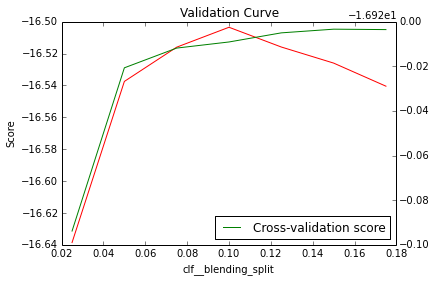

In [9]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# 'clf__blending_split', [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175]
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

# Generate submission

In [19]:
pip.fit(X, y)

Pipeline(copy=True,
     steps=[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', BlendedRegressor(base_models=(Pipeline(copy=True,
     ...lse, random_state=None, solver='auto', tol=0.001),
         blending_split=0.2, with_feature=True))])

In [20]:
test = pd.read_csv('../data/test.csv')
test_comb = test.groupby('Id').agg(['mean','std','median','count','min', 'max'])
test_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(test_comb.columns.values)]
test_withRef_comb = test_comb[pd.notnull(test_comb.Ref_mean)]
test_withRef_comb['MP'] = np.log10(1+pow(pow(10, test_withRef_comb['Ref_mean']/10)/200, 0.625 * 0.82))

test_X = test_withRef_comb.loc[:, 'minutes_past_mean':'MP']   # NOTE: used range slicing on column
test_y_predict = 10**pip.predict(X=test_X)-1

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
# Ref-samples
test_result_withRef = pd.DataFrame()
test_result_withRef['Id'] = test_withRef_comb.index
test_result_withRef['Expected'] = test_y_predict
# All-samples
test_result = pd.DataFrame()
test_result['Id'] = test['Id'].unique()
# Merge and set Non-Ref samples to -1
test_result = pd.merge(test_result, test_result_withRef, how='left', on=['Id'], sort=True)
test_result.loc[test_result['Expected'].isnull(), 'Expected'] = -1
# Write file
datetime_str = time.strftime('%Y%m%d_%H%M%S')
test_result.to_csv('../data/result_'+datetime_str+'.csv', index=False)
print '../data/result_'+datetime_str+'.csv'

../data/result_20151128_061852.csv
